This chapter focuses on building a reduced model of the Mouse Primary Visual Cortical Area (V1) mainly focusing on cells in Layer 4 (L4). In this notebook, we compute estimates of the neuronal composition based on the mouse datasets from the Allen Brain Atlas (ABC). 

## Allen Brain Cell Atlas (ABC) Mouse Datasets

  - Allen Brain Cell Atlas (ABC) includes the following Single cell datasets from mouse brain
      - Yao et. al. (2023) : Two large gene expression datasets and a Spatial Gene expression dataset
      - Zhang et. al. (2023) : Three Spatial Gene expresion datasets
  - Focus of this notebook : Yao et. al. (2023) Spatial Transcriptomics Dataset :
      - 500 gene panel MERFISH dataset of ~4.0 million cells.
      - Dataset obtained from single adult male.
      - 59 coronal sections (10 micron thick) covering the whole anterior to posterior extent of the brain (~200 micron apart).
  - In a MERFISH assay, in addition to gene expression data, each cell also has x, y, z coordinates:
      - x and y generated by rotating each section so that it is upright with midline approximately in the middle of the frame.
      - z coordinate takes into account the physical spacing between each section


# Install Dependencies
Install two libraries:
  - airavata-cerebrum library, which provides utilities to translate data from atlas to a format that can be used by models
  - abc_atlas_access to enable downloading data from Allen Brain Atlas 

In [2]:
!pip install git+https://github.com/srirampc/airavata-cerebrum.git

  Cloning https://github.com/srirampc/airavata-cerebrum.git to /scratch/1684403/pip-req-build-2hpwrbau
  Running command git clone --quiet https://github.com/srirampc/airavata-cerebrum.git /scratch/1684403/pip-req-build-2hpwrbau
  Resolved https://github.com/srirampc/airavata-cerebrum.git to commit 02245cd05d1713c76262442031559c1e89a9809d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-2.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached airavata_python_sdk-1.1.7-py2.py3-none-any.whl.metadata (254 bytes)
  Using cached intervaltree-3.1.0-py2.py3-none-any.whl
  Using cached numpy-2.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached matplotlib-3.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86

In [3]:
!pip install git+https://github.com/AllenInstitute/abc_atlas_access.git

  Cloning https://github.com/AllenInstitute/abc_atlas_access.git to /scratch/1684403/pip-req-build-s1h5d_d5
  Running command git clone --quiet https://github.com/AllenInstitute/abc_atlas_access.git /scratch/1684403/pip-req-build-s1h5d_d5
  Resolved https://github.com/AllenInstitute/abc_atlas_access.git to commit bb3f4c95be992e6535d8bc7c2d974cd78db95148
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ghp_import-2.1.0-py3-none-any.whl.metadata (7.2 kB)
  Using cached pytest-8.2.2-py3-none-any.whl.metadata (7.6 kB)
  Using cached SimpleITK-2.3.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.10.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached cryptography-42.0.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.3 kB)
  Using cached xmltodict-0.13.

In [16]:
import airavata_cerebrum.atlas.data.abc_mouse as abc_mouse
import airavata_cerebrum.atlas.model.regions as regions
import airavata_cerebrum.atlas.model.builder as builder
import airavata_cerebrum.atlas.operations.netops as netops
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## Step 1 : Download the MERFISH Data
- Download using AbcProjectCache library
- Define a data directory to store the data

In [5]:
# Downloading the necessary data
download_base = "../cache/abc_mouse"
abc_cache = AbcProjectCache.from_s3_cache(download_base)
abc_cache.load_latest_manifest()

In [6]:
abc_cache.get_directory_metadata("MERFISH-C57BL6J-638850")

cell_metadata.csv: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 564M/564M [03:33<00:00, 2.64MMB/s]
cell_metadata_with_cluster_annotation.csv: 100%|█████████████████████████████████████████████████████████████████████████| 1.02G/1.02G [01:18<00:00, 13.0MMB/s]
example_genes_all_cells_expression.csv: 100%|██████████████████████████████████████████████████████████████████████████████| 360M/360M [01:22<00:00, 4.38MMB/s]
gene.csv: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 48.4k/48.4k [00:00<00:00, 508kMB/s]


[PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/MERFISH-C57BL6J-638850/20231215/cell_metadata.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/MERFISH-C57BL6J-638850/20231215/views/cell_metadata_with_cluster_annotation.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/MERFISH-C57BL6J-638850/20231215/views/example_genes_all_cells_expression.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/MERFISH-C57BL6J-638850/20231215/gene.csv')]

In [7]:
abc_cache.get_directory_metadata("MERFISH-C57BL6J-638850-CCF")

ccf_coordinates.csv: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 296M/296M [01:31<00:00, 3.25MMB/s]
cell_metadata_with_parcellation_annotation.csv: 100%|████████████████████████████████████████████████████████████████████| 1.61G/1.61G [04:41<00:00, 5.70MMB/s]
reconstructed_coordinates.csv: 100%|███████████████████████████████████████████████████████████████████████████████████████| 256M/256M [01:47<00:00, 2.39MMB/s]


[PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/MERFISH-C57BL6J-638850-CCF/20231215/ccf_coordinates.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/MERFISH-C57BL6J-638850-CCF/20231215/views/cell_metadata_with_parcellation_annotation.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/MERFISH-C57BL6J-638850-CCF/20231215/reconstructed_coordinates.csv')]

In [9]:
abc_cache.get_directory_metadata("WMB-taxonomy")

cluster.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 131k/131k [00:00<00:00, 305kMB/s]
cluster_annotation_term.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 861k/861k [00:01<00:00, 633kMB/s]
cluster_annotation_term_set.csv: 100%|███████████████████████████████████████████████████████████████████████████████████| 1.11k/1.11k [00:00<00:00, 9.82kMB/s]
cluster_annotation_term_with_counts.csv: 100%|██████████████████████████████████████████████████████████████████████████████| 902k/902k [00:01<00:00, 737kMB/s]
cluster_to_cluster_annotation_membership.csv: 100%|███████████████████████████████████████████████████████████████████████| 2.21M/2.21M [00:02<00:00, 973kMB/s]
cluster_to_cluster_annotation_membership_color.csv: 100%|███████████████████████████████████████████████████████████████████| 239k/239k [00:00<00:00, 806kMB/s]
cluster_to_cluster_annotation_membership

[PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/WMB-taxonomy/20231215/cluster.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/WMB-taxonomy/20231215/cluster_annotation_term.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/WMB-taxonomy/20231215/cluster_annotation_term_set.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/WMB-taxonomy/20231215/views/cluster_annotation_term_with_counts.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/WMB-taxonomy/20231215/cluster_to_cluster_annotation_membership.csv'),
 PosixPath('/storage/hive/project/ideas-aluru/schockalingam6/bmtk-workshop/cache/abc_mouse/metadata/WMB-taxonomy/20231215/views/cluster_to_cluster_annotation_membership_color.csv'),
 PosixPath('/storage/hive/proj

## Structure of Gene Expression Data

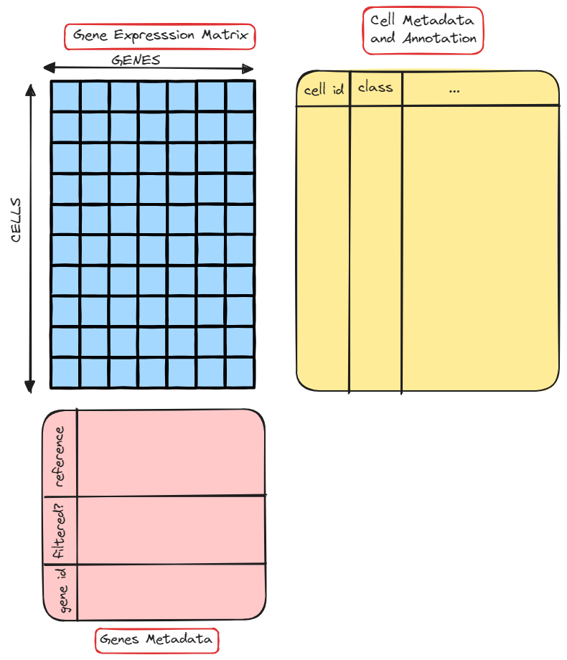


Gene expression datasets can be seen as composed of three tables :

 - Gene Expression Data
 - Cell meta data
     - Experiment: e.g. disease, organism, sex, donor, etc.
     - Region: e.g. layer, region, etc.
     - Stats & Analysis: e.g. ncounts, cell type, etc.
 - Gene meta data
     - Avg. expression level, Is highly variable, etc.



## ABC cell metadata
   - Loading the gene and cell metadata from the atlas.data.abc_mouse package
   - cell meta data contains the cell-specific information such as donor, section etc.
   - atlas.data.abc_mouse also includes options to extend the cell metadata to include the cluster aliases

### Whole Brain Taxonomy Data

The Allen Brain Cell Atlas includes an integrated transcriptomic taxonomy that contains

- 5,322 clusters that are organized in a hierarchical manner
  - Top level of 34 classes
  - Second-level of 338 subclasses
  - Third-level of 1,201 supertypes and
  - Fourth-level of 5,322 types/clusters.

Example of classes:

    '01 IT-ET Glut',
    '02 NP-CT-L6b Glut',
    '03 OB-CR Glut',
    '04 DG-IMN Glut',
    '05 OB-IMN GABA',
    '06 CTX-CGE GABA',
    '07 CTX-MGE GABA',
    '08 CNU-MGE GABA',
    '09 CNU-LGE GABA'


In [10]:
# Load Cell metadata and Gene metadata 
ABC_ATLAS_BASE = download_base
manifest, file_meta = abc_mouse.merfish_files_meta()
cell_meta = abc_mouse.cell_metadata(file_meta, ABC_ATLAS_BASE)
gene_meta = abc_mouse.gene_metadata(file_meta, ABC_ATLAS_BASE)
# Extend the cell meta data to include taxonomy data, class, subclass and types of all the cells
cluster_details, cluster_colors = abc_mouse.taxonomy_cluster(manifest, ABC_ATLAS_BASE)
cell_meta_ext = cell_meta.join(cluster_details, on="cluster_alias")
cell_meta_ext = cell_meta_ext.join(cluster_colors, on="cluster_alias")

In [11]:
cell_meta_ext

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x,y,z,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cell_label,,,,,,,,,,,,,,,,,,,,
1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,6.6,,04 DG-IMN Glut,038 DG-PIR Ex IMN,0141 DG-PIR Ex IMN_2,0515 DG-PIR Ex IMN_2,#666666,#16f2f2,#3D53CC,#CC7A3D,#73FFBF
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018093344100380167-3,C57BL6J-638850.47,5252,0.574988,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.560003,4.669243,8.8,,33 Vascular,333 Endo NN,1193 Endo NN_1,5309 Endo NN_1,#666666,#858881,#994567,#00992A,#5C9994
1017165415100930567,C57BL6J-638850.57,5254,0.620546,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.032556,3.695696,11.0,,33 Vascular,333 Endo NN,1193 Endo NN_1,5310 Endo NN_1,#666666,#858881,#994567,#00992A,#FFB473
1017155956102610748,C57BL6J-638850.49,5254,0.548053,C57BL6J-638850,C57BL6J-638850,wt/wt,M,2.549142,4.231188,9.2,,33 Vascular,333 Endo NN,1193 Endo NN_1,5310 Endo NN_1,#666666,#858881,#994567,#00992A,#FFB473



## Step 2: Obtain Region Specific Ratios using our Interface

### Function: atlas.data.abc_mouse.region_cell_type_ratios 

 - Obtain region specific reatios **based on the parcelletion information of the Allen CCF**.
 - Description of the functionality
    1. Obtain data frame with flags set indicating the cell types and cell sub-types from the meta data 
    2. Group by the layers in sub-region to obtain summary statistics 
    3. Compute the ratios in each layer
    4. The above three steps is computed for each layer and merge all the data

In [13]:
## Obtain Region Specific Ratios
v1_ei_df = abc_mouse.region_cell_type_ratios("VISp", ABC_ATLAS_BASE)
v1_ei_df

,Region,Layer,nregion,inhibitory fraction,fraction wi. region,Sst fraction,Lamp5 fraction,Sst-Chodl fraction,Pvalb fraction,Vip fraction,GABA-Other fraction,IT-CTX fraction,IT-ENT fraction,IT-Other fraction,IT fraction,ET fraction,CT fraction,NP fraction,Glut-Other fraction
parcellation_substructure,,,,,,,,,,,,,,,,,,,
VISp1,VISp,1,61884,0.405155,0.069663,0.035623,0.720102,0.007634,0.038168,0.147583,0.050891,0.986135,0.001733,0.001733,0.989601,0.000000,0.000000,0.000000,0.010399
VISp2/3,VISp,2/3,61884,0.078755,0.348620,0.161912,0.158345,0.002140,0.332382,0.316690,0.028531,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
VISp4,VISp,4,61884,0.111916,0.209699,0.315126,0.018487,0.000000,0.532773,0.131933,0.001681,0.962618,0.000000,0.000000,0.962618,0.029334,0.000212,0.007413,0.000424
VISp5,VISp,5,61884,0.165428,0.177606,0.455797,0.022464,0.006522,0.487681,0.021739,0.005797,0.519247,0.001867,0.000144,0.521258,0.323039,0.043953,0.104137,0.007613
VISp6a,VISp,6a,61884,0.062779,0.163661,0.348540,0.025547,0.010949,0.562044,0.038321,0.014599,0.212443,0.001711,0.001834,0.215988,0.000611,0.759320,0.005378,0.018702
VISp6b,VISp,6b,61884,0.052910,0.030751,0.275000,0.087500,0.075000,0.475000,0.037500,0.050000,0.042598,0.000000,0.004190,0.046788,0.000000,0.725559,0.000000,0.227654


### Transcriptomic cell types defined by the atlas

 - Inhibitory types : 
    - 'Vip', 
    - 'Pvalb', 
    - 'SSt', 
    - 'Lamp5', 
    - 'Sst-Chodl',
    - 'GABA-Other' (Inhibitory cells that are not one of Vip, Pvalb, SSt, SST-Chodl)
 - Exitatory types :
    - "IT",
    - "ET",
    - "CT",
    - "NP",
    - "Glut-Other"(Excitatory cells that are not one of IT, ET, CT or NP)
 - IT types are further classified as
    - "IT-CTX",
    - "IT-ENT" and
    - "IT-Other"

## Step 3: Operations on the data obtained from Atlas

1. Function: atlas.operations.netops.atlasdata2regionfractions
     - Convert data frame to an intermediate data structure
2. Function: atlas.operations.netops.fractions2ncells
     - Compute the number of cells based on the ratios
3. Function: atlas.operations.netops.subset_network
     - Generate a subset of the network data

In [17]:
## V1 Fractions to Counts
v1net_data = netops.atlasdata2regionfractions(v1_ei_df, "v1") 
v1net_data = netops.fractions2ncells(v1net_data, 300000)
v1net_data = netops.subset_network(v1net_data, ["VISp4"])
v1net_data.locations["VISp4"].neurons

{'Sst': Neuron(ei='i', fraction=0.31512605042016806, N=2218, dims={}, model_name='', model_type='', model_template='', dynamics_params=''),
 'Lamp5': Neuron(ei='i', fraction=0.018487394957983194, N=130, dims={}, model_name='', model_type='', model_template='', dynamics_params=''),
 'Sst-Chodl': Neuron(ei='i', fraction=0.0, N=0, dims={}, model_name='', model_type='', model_template='', dynamics_params=''),
 'Pvalb': Neuron(ei='i', fraction=0.5327731092436975, N=3750, dims={}, model_name='', model_type='', model_template='', dynamics_params=''),
 'Vip': Neuron(ei='i', fraction=0.1319327731092437, N=928, dims={}, model_name='', model_type='', model_template='', dynamics_params=''),
 'GABA-Other': Neuron(ei='i', fraction=0.0016806722689075631, N=11, dims={}, model_name='', model_type='', model_template='', dynamics_params=''),
 'IT': Neuron(ei='e', fraction=0.9626178121359737, N=53780, dims={}, model_name='', model_type='', model_template='', dynamics_params=''),
 'ET': Neuron(ei='e', frac

### Save to json format
- Save to json format

In [18]:
import json
with open("abc_stats.json", "w") as ofx: 
    jsx = v1net_data.model_dump_json(indent=4)
    ofx.write(jsx)

In [19]:
!cat "abc_stats.json"

{
    "name": "v1",
    "locations": {
        "VISp4": {
            "name": "VISp4",
            "inh_fraction": 0.1119157340355497,
            "region_fraction": 0.20969879128692392,
            "neurons": {
                "Sst": {
                    "ei": "i",
                    "fraction": 0.31512605042016806,
                    "N": 2218,
                    "dims": {},
                    "model_name": "",
                    "model_type": "",
                    "model_template": "",
                    "dynamics_params": ""
                },
                "Lamp5": {
                    "ei": "i",
                    "fraction": 0.018487394957983194,
                    "N": 130,
                    "dims": {},
                    "model_name": "",
                    "model_type": "",
                    "model_template": "",
                    "dynamics_params": ""
                },
                "Sst-Chodl": {
                    "ei": "i",
                    "f